## A 1-d Fourier Neural Operator
An example notebook demonstrating how to implement a Fourier Neural Operator using the new `Flax NNX`. 
The `nnx.Einsum` layer, which combines Einstein summation with a learnable kernel (and optionally a bias—though the bias isn't needed for FNO), eliminates the need to separately define a parameter for spectral weights or write a custom function for complex multiplication.

Acknowledgement: This notebook is based on [this amazing tutorial](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_FNO_in_JAX.ipynb) by Felix Köhler. 



In [314]:
import jax
import jax.numpy as jnp
import numpy as np
from flax import nnx
import optax
import matplotlib.pyplot as plt
from typing import Callable
from tqdm.autonotebook import tqdm
import scipy

In [5]:
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

--2025-01-26 12:02:52--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 23.37.96.194
Connecting to ssd.mathworks.com (ssd.mathworks.com)|23.37.96.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M  62.0MB/s    in 11s     

2025-01-26 12:03:04 (57.1 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [216]:
data = scipy.io.loadmat("burgers_data_R10.mat")
a, u = data["a"], data["u"]
a.shape

(2048, 8192)

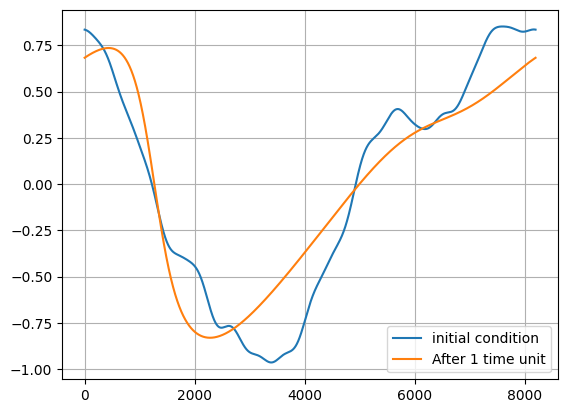

In [217]:
plt.plot(a[0], label="initial condition")
plt.plot(u[0], label="After 1 time unit")
plt.legend()
plt.grid()

In [218]:
# nnx uses channel last convention 
a = a[:, :, jnp.newaxis]
u = u[:, :, jnp.newaxis]

In [219]:
train_x, test_x = a[:1000], a[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

In [297]:
class SpectralConv1d(nnx.Module):
    """SpectralConv1d Layer"""

    def __init__(
        self,
        modes: int,
        in_channels: int,
        out_channels: int,
        rngs: nnx.Rngs,
    ):
        self.modes = modes
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.mult_real = nnx.Einsum(
            einsum_str="BMI,IMO->BMO",
            kernel_shape=(self.in_channels, self.modes, self.out_channels),
            bias_shape=None,
            rngs=rngs
        )

        self.mult_imag = nnx.Einsum(
            einsum_str="BMI,IMO->BMO",
            kernel_shape=(self.in_channels, self.modes, self.out_channels),
            bias_shape=None,
            rngs=rngs,
        )


    def __call__(
        self,
        x: jnp.array,
    ):
        batch_size, length, _ = x.shape
        
        x_ft = jnp.fft.rfft(x, axis=1)
        
        x_ft_truncated = x_ft[:, :self.modes, :]
        out_ft_real = self.mult_real(x_ft_truncated) - self.mult_imag(x_ft_truncated)
        out_ft_imag = self.mult_real(x_ft_truncated) + self.mult_imag(x_ft_truncated)
        out_ft = jnp.zeros(
            (batch_size, length//2+1, self.out_channels),
            dtype=jnp.complex64)
        out_ft = out_ft.at[:, :self.modes, :].set(out_ft_real + 1j * out_ft_imag)
        x_out = jnp.fft.irfft(out_ft, n=length, axis=1)
        return x_out


In [298]:
class FourierLayer1d(nnx.Module):
    
    def __init__(
        self,
        modes: int,
        in_channels: int,
        out_channels: int,
        activation: Callable,
        rngs: nnx.Rngs,
    ):
        self.spectral_conv = SpectralConv1d(
            modes,
            in_channels,
            out_channels,
            rngs=rngs,
        )
        self.local = nnx.Conv(
            in_channels,
            out_channels,
            1,
            rngs=rngs,
        )
        self.activation = activation

    def __call__(
        self,
        x
    ):
        x_fourier = self.spectral_conv(x)
        x_local = self.local(x)
        return self.activation(x_fourier + x_local)

In [299]:
class FNO1d(nnx.Module):

    def __init__(
        self,
        modes: int = 32,
        width: int = 64,
        depth: int = 4,
        padding: int = 2,
        in_channels: int = 3,
        out_channels: int = 1,
        channels_last_proj: int = 128,
        activation: Callable = nnx.gelu,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):

        self.activation = activation
        self.depth = depth
        self.padding = padding

        self.lifting = nnx.Conv(
            in_channels + 1,
            width,
            1,
            rngs=rngs,
        )

        self.fno_layers = []
        for depthnum in range(depth):
            activation = self.activation 
            self.fno_layers.append(
                FourierLayer1d(
                    modes=modes,
                    in_channels=width,
                    out_channels=width,
                    activation=activation,
                    rngs=rngs,
                )
            )

        self.proj1 = nnx.Linear(
            in_features=width,
            out_features=channels_last_proj,
            rngs=rngs
        )
        self.proj2 = nnx.Linear(
            in_features=channels_last_proj,
            out_features=out_channels,
            rngs=rngs
        )
        
    @staticmethod
    def get_grid(x):
        grid = jnp.linspace(0, 1, x.shape[1])
        grid = jnp.expand_dims(grid, axis=-1)
        batched_grid = jnp.repeat(grid[None,:,:], x.shape[0], axis=0)
        return batched_grid


    def __call__(
        self,
        x,
    ):
        grid = self.get_grid(x)
        x = jnp.concatenate([x, grid], axis=-1)
        x = self.lifting(x)
        if self.padding > 0:
            pad_width = [(0, 0), (0, self.padding), (0, 0)]
            x = jnp.pad(x, pad_width, mode='constant')

        
        for fnolayer in self.fno_layers:
            x = fnolayer(x)

        if self.padding > 0:
            x = x[:, :-self.padding, :]


        x = self.proj1(x)
        x = nnx.gelu(x)
        x = self.proj2(x)

        return x

In [300]:
model = FNO1d(
    modes = 16,
    width = 64,
    depth = 4,
    padding = 0,
    in_channels = 2,
    out_channels = 1,
    channels_last_proj = 32,
    activation=nnx.gelu,
    rngs = nnx.Rngs(0),
)

In [301]:
learning_rate = 3e-4
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate))
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss')
)

In [302]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [303]:
def loss_fn(
    model: FNO1d,
    x: jnp.array,
    y: jnp.array,
):
    opt = model(x)
    loss = optax.l2_loss(opt, y).mean()
    return loss

In [304]:
@nnx.jit
def train_step(
    model: FNO1d,
    optimizer: nnx.Optimizer,
    x: jnp.array,
    y: jnp.array,
):
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, x, y)
    optimizer.update(grads)
    return loss


@nnx.jit
def eval_step(
    model: FNO1d,
):
    loss = loss_fn(model, test_x[:,::32,:], test_y[:,::32,:])
    return loss

In [305]:
shuffle_key = jax.random.PRNGKey(10)
train_loss_hist = []
val_loss_hist = []

for epoch in tqdm(range(200)):
    losses = []
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for step, (batch_x, batch_y) in enumerate(dataloader(
        subkey,
        train_x[:, ::32, :],
        train_y[:, ::32, :],
        batch_size=100
    )):
        loss = train_step(model, optimizer, batch_x, batch_y)
        losses.append(np.asarray(loss))

    val_loss = eval_step(model)
    train_loss = np.mean(np.array(losses))
#    print(f'Epoch {epoch} train_loss: {train_loss}')
#    print(f'Epoch {epoch} eval_loss: {val_loss}')
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)


100%|██████████| 200/200 [00:22<00:00,  9.08it/s]


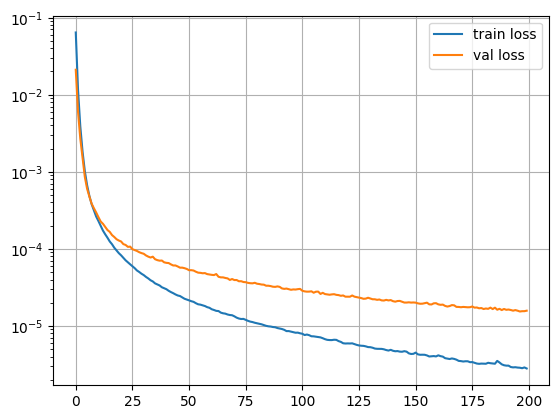

In [306]:
plt.plot(train_loss_hist, label="train loss")
plt.plot(val_loss_hist, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

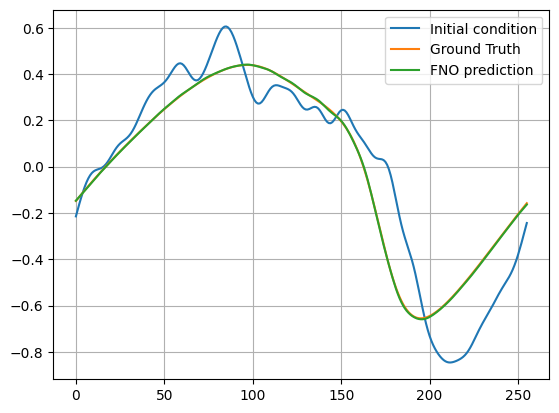

In [307]:
plt.plot(test_x[1,::32,0], label="Initial condition")
plt.plot(test_y[1,::32,0], label="Ground Truth")
plt.plot(model(test_x[1,::32,:][None,:,:])[0], label="FNO prediction")
plt.legend()
plt.grid()

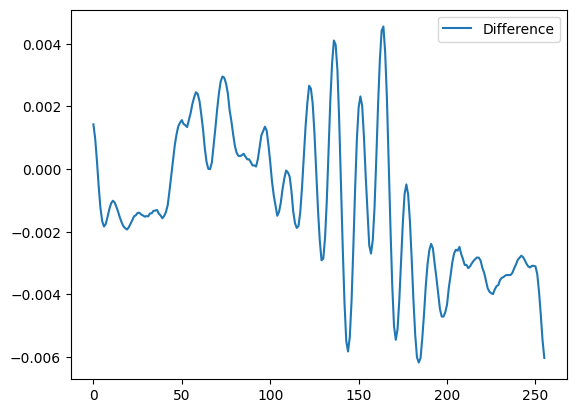

In [308]:
plt.plot(model(test_x[1,::32,:][None,:,:]).squeeze() - test_y[1,::32,0].squeeze(), label="Difference")
plt.legend()

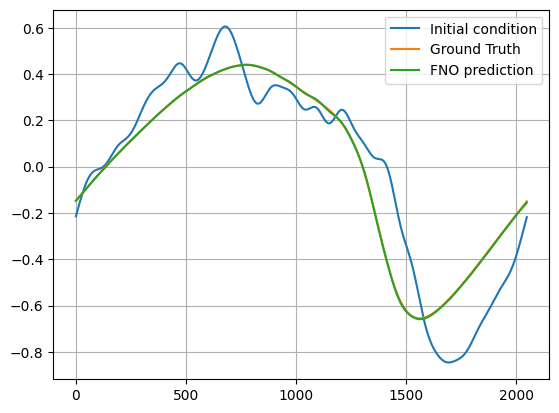

In [309]:
plt.plot(test_x[1,::4,0], label="Initial condition")
plt.plot(test_y[1,::4,0], label="Ground Truth")
plt.plot(model(test_x[1,::4,:][None,:,:])[0], label="FNO prediction")
plt.legend()
plt.grid()

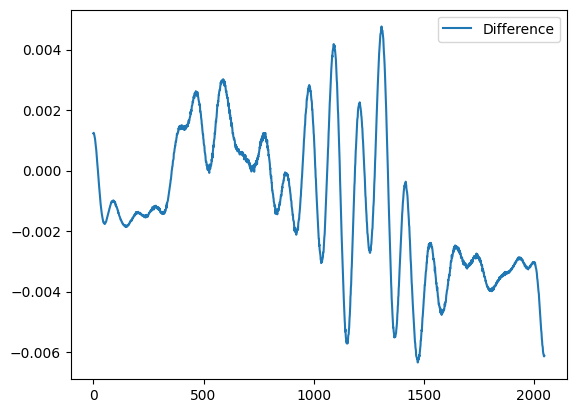

In [310]:
plt.plot(model(test_x[1,::4,:][None,:,:]).squeeze() - test_y[1,::4,0].squeeze(), label="Difference")
plt.legend()

In [315]:
# Compute the error as reported in the FNO paper
test_pred = model(test_x)

def relative_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

rel_l2_set = jax.vmap(relative_l2_norm)(test_pred, test_y)

In [316]:
rel_l2_set.shape

(200,)

In [317]:
jnp.mean(rel_l2_set) # ~1e-2

Array(0.00729159, dtype=float32)